# Limpieza y Normalización de características

## Imports e Inicializaciones necesarias

In [1]:
import pandas as pd
import spacy
import re
import numpy as np
import nltk
import operator
import heapq
import ast
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import wikipedia
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import gensim
from sklearn import preprocessing
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from nltk import word_tokenize
from nltk.corpus import stopwords

black_list = ['más', 'mas', 'unir', 'paises', 'pais', 'espa', 'no', 'os', 'a', 'compa', 'acompa', 'off', 'and', 'grecia', 'the','it', 'to',
              'd',  'et',  'dame',  'il',  'dans', 'that',  'as',   'for',  'it',  'elections',  'would',  'this',  'with', 'york', 'obama', 'chavez', 'gadafi']

stop = set(stopwords.words('spanish'))
additional_stopwords=set(black_list)
stopwords = stop.union(additional_stopwords)
nltk.download('stopwords')
nltk.download('punkt')

ner_dict = {0: 'PER', 1: 'MISC', 2: 'ORG', 3: 'UND'}
regex = "[a-zA-Z0-9]*_[a-zA-Z0-9]*"
nlp = spacy.load('es_core_news_sm')
nlp.max_length = 3000000
nlp2 = spacy.load('es_core_news_md')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/juanmoreno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/juanmoreno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Funciones auxiliares

In [2]:
def getDuplicatesWithCount(listOfElems):
    ''' Get frequency count of duplicate elements in the given list '''
    dictOfElems = dict()
    # Iterate over each element in list
    for elem in listOfElems:
        # If element exists in dict then increment its value else add it in dict
        if elem in dictOfElems:
            dictOfElems[elem] += 1
        else:
            dictOfElems[elem] = 1    
 
    # Filter key-value pairs in dictionary. Keep pairs whose value is greater than 1 i.e. only duplicate elements from list.
    dictOfElems = { key:value for key, value in dictOfElems.items()} #  if value > 1
    # Returns a dict of duplicate elements and thier frequency count
    return dictOfElems

def class_ents(text):
    classify = ""
    if text.ents:
        for ent in text.ents:
            classify = ent.label_
    return classify

def tag_user(screen_name, profile_name):
    c = "UND"
    if re.findall(regex, screen_name):
        screen_name = re.sub(r"_", " ", str(screen_name))
    screen_name = screen_name.strip()
    screen_name = screen_name[0].upper() + screen_name[1:]
    c1 = class_ents(nlp(profile_name))
    c2 = class_ents(nlp(screen_name))
    if c1 == c2 and c1 != "":
        c = c1
    else:
        if c2:
            c = c2
    if c1 == "PER" or c2 == "PER" or c1 == "LOC" or c2 == "LOC":
        c = "PER"
    return c

def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in black_list and len(token.text)>2]
    return texts_out

def display_topics(model, model_type="lda"):
  for topic_idx, topic in enumerate(model.print_topics()):
    print ("Topic %d:" % (topic_idx))
    if model_type== "hdp":
      print (" ".join(re.findall( r'\*(.[^\*-S]+).?', topic[1])), "\n")
    else:
      print (" ".join(re.findall( r'\"(.[^"]+).?', topic[1])), "\n")

def evaluate_graph(dictionary, corpus, texts, limit, model):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        if model == 'lsi':
          lm = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        else:
          lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

def format_topics_sentences(n, model, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()-n

    # Get main topic in each document
    for i, row in enumerate(model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [3]:
# lectura del csv a normalizar
df = pd.read_csv("TWEETS_CENTRALIDAD/tweets_NB2_3_1_CENTRALIDAD.csv")

df.head()
df_final = pd.DataFrame()

#### verificado

In [4]:
tratra = {0:False, 1:True}
rev_subs = { v:k for k,v in tratra.items()}
columna_final = [rev_subs.get(item,item) for item in df['verificado'].tolist()]
df_final['verificado'] = columna_final

#### hater

In [5]:
hate_percentage = df['hate'] * 100 / df['status_retrieving']
haters = hate_percentage > 5
df_final['hater'] = haters

#### clase NER

In [6]:
users_tagged = []
for i, v in df.iterrows():
    tag = tag_user(v['screen_name'], v['user_name'])
    users_tagged.append(tag)
rev_subs = { v:k for k,v in ner_dict.items()}
fin = [rev_subs.get(item,item) for item in users_tagged]
df_final['clase_NER'] = fin

#### clase DESCR

/home/juanmoreno/anaconda3/envs/TFG/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


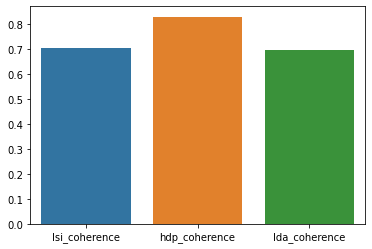

In [14]:
df['descripcion'] = df['descripcion'].fillna('')
bigram = gensim.models.Phrases(df['descripcion'].to_list())

bigram_list = bigram[df['descripcion'].to_list()]
out_text = lemmatization(" ".join(bigram_list))

dataset = [d.split() for d in out_text]
dictionary = Dictionary(dataset)
dictionary.compactify()
# Filter extremes
dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary.compactify()
corpus = [dictionary.doc2bow(text) for text in dataset]

hdpmodel = HdpModel(corpus=corpus, id2word=dictionary, random_state= 30)
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=dataset, dictionary=dictionary, window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=dataset, dictionary=dictionary, window_size=10).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics, texts=dataset, dictionary=dictionary, window_size=10).get_coherence()

coherences = [lsi_coherence, hdp_coherence, lda_coherence]
n = len(coherences)
x = ['lsi_coherence','hdp_coherence', 'lda_coherence']
sns.barplot(x, coherences)

df_topic_sents_keywords = format_topics_sentences(n, model=hdpmodel, corpus=corpus, texts=dataset)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].fillna(0)
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype('int64')

label_dicc = {0:'opinión', 1:'estudios', 2:'política', 3: 'actividades'}

opinion = df_dominant_topic['Keywords'][0] + df_dominant_topic['Keywords'][4]
estudios = df_dominant_topic['Keywords'][1] + df_dominant_topic['Keywords'][6]
politica = df_dominant_topic['Keywords'][2] + df_dominant_topic['Keywords'][5] + df_dominant_topic['Keywords'][8]
actividades = df_dominant_topic['Keywords'][3] + df_dominant_topic['Keywords'][7]
df_dominant_topic_final = pd.DataFrame(columns=['text', 'label'])

matriz_textos = []
for i in [opinion, estudios, politica, actividades]:
    list_to_str = ",".join([i])
    matriz_textos.append(list_to_str)

for index, lista_textos in enumerate(matriz_textos):
    df_dominant_topic_final.at[index, 'text'] = lista_textos

matriz_labels = []
for i in label_dicc.values():
    matriz_labels.append(i)

for index, lista_labels in enumerate(matriz_labels):
    df_dominant_topic_final.at[index, 'label'] = lista_labels

# df['Title'] = df['Title'].str.replace('\(\(\(', '>>')
### Clasificacion de la descripcion por temas
for i,v in df.iterrows():
    for j,y in df_dominant_topic_final.iterrows():
        a_dictionary = {"count0": 0, "count1": 0, "count2": 0, "count3": 0}
        for word in y['text'].split(', '):
            string = word.replace('(', '')
            
            if re.search(string, str(v['descripcion'])) != None:
                if j == 0:
                    a_dictionary["count0"] += 1
                elif j == 1:
                    a_dictionary["count1"] += 1
                elif j == 2:
                    a_dictionary["count2"] += 1
                elif j == 3:
                    a_dictionary["count3"] += 1
                max_key = max(a_dictionary, key=a_dictionary.get)
                if max_key == "count0":
                    df_final.at[i,'clase_DESCR'] = 0
                elif max_key == "count1":
                    df_final.at[i,'clase_DESCR'] = 1
                elif max_key == "count2":
                    df_final.at[i,'clase_DESCR'] = 2
                elif max_key == "count3":
                    df_final.at[i,'clase_DESCR'] = 3

#### clase_FECHA

In [15]:
import datetime
from datetime import datetime

# df = df.drop(labels=[517], axis=0)

clase_fecha = []
index = 0

for item in df['fecha_creacion']:
    datem = datetime.strptime(item[:19], "%Y-%m-%d %H:%M:%S")
    anyo = datem.year
    if int(anyo) < 2015:
        clase_fecha.append(0)
    elif int(anyo) >= 2015 and int(anyo) < 2019:
        clase_fecha.append(1)
    elif int(anyo) >= 2019:
        clase_fecha.append(2)

#print(len(clase_fecha))
#df_final = df_final.drop(labels=[517], axis=0)
df_final['clase_FECHA'] = clase_fecha

#### clase_HASHTAGS

In [16]:
import math

hashtags = []
x = []
df_hashtags = pd.DataFrame(columns=['hashtags'])

df['top_hashtags'] = df['top_hashtags'].fillna('{}')

for content in df['top_hashtags']:
    x.append(list(ast.literal_eval(content).keys()))
    hashtags.extend(ast.literal_eval(content).keys())
df_hashtags['hashtags'] = x

flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in df_hashtags.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])

popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

# take hashtags which appear at least this amount of times
min_appearance = 5
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])

# make a new column with only the popular hashtags
df_hashtags['popular_hashtags'] = df_hashtags.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])

# drop rows without popular hashtag
popular_hashtags_list_df = df_hashtags.loc[
            df_hashtags.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]

# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))

diccionario_manual = {"política" : ['Marlaska', "Paro", "Ayuso", "Izquierda", "Derecha", "Vox", 
                                    "4demayo", "2demayo","4Mayo", "PSOE", "8M", "4M", "Nazi", 
                                    "Elecciones", "Vota", "Reforma", "VotaLibertad", 
                                    "ProtegeMadrid", u"Corrupción", "Voto", "Reforma", 
                                    "Ley", u"Artículo", u"Abstención", "Abstenerse", 
                                    "Dictadura", "Libertad", "Comunismo", "Ultraderecha", 
                                    "Democracia", "Fascismo", "Fascista", "Facha", "Menas", 
                                    "Democratica", "Gobierno", u"Autonomías", "Aborto", 
                                    "Derechos", "Derecho", u"Represión", "PP", u"MásMadrid", 
                                    "Cs", "Ciudadanos"],
                      "prensa": ["UltimaHora", "News", "AHORA", u"ATENCIÓN", "COVID", u"COVID-19", 
                                 "COVID19", "Colombia", "Cadena", "Pandemia", "Coronavirus", 
                                 "QuedateEnCasa", "YoMeQuedoEnCasa"], 
                      "deportes": ["Superliga", "HalaMadrid", "Atleti", "Jugones", "GranadaEibar", "Tokio2020", "GP", 
                                   "UEFA", "Champions", "Liga", "Futbol", "Baloncesto", "Tenis", "FC", "Levante", "Sevilla",
                                   "Betis", "RayoVallecano", "Barça", "Barcelona", "Elche", "RealMadrid", u"Clásico",
                                   "Eurocopa", "League", "Chiringuito"]}

df['top_hashtags'] = df['top_hashtags'].fillna({})
for i,v in df.iterrows():
    user = v.top_hashtags
    if str(user) == '0' or str(user) == 'False':
        df_final.at[i,'clase_HASHTAGS'] = int(0)
    else:
        a_dictionary = {"count0": 0, "count1": 0, "count2": 0, "count3": 0}
        for clase in list(ast.literal_eval(user).keys())[:3]:
            for j,y in diccionario_manual.items():
                for word in y:
                    if re.search(word.lower(), clase.lower()) != None:
                        if j == "política":
                            a_dictionary["count0"] += 1
                        elif j == "prensa":
                            a_dictionary["count1"] += 1
                        elif j == "deportes":
                            a_dictionary["count2"] += 1
                    elif re.search(word.lower(), clase.lower()) == None:
                        a_dictionary["count3"] = 1
                max_key = max(a_dictionary, key=a_dictionary.get)
                if max_key == "count0":
                    df_final.at[i,'clase_HASHTAGS'] = int(0)
                elif max_key == "count1":
                    df_final.at[i,'clase_HASHTAGS'] = int(1)
                elif max_key == "count2":
                    df_final.at[i,'clase_HASHTAGS'] = int(2)
                elif max_key == "count3": # otros
                    df_final.at[i,'clase_HASHTAGS'] = int(3)
                
df_final['clase_DESCR'] = df_final['clase_DESCR'].fillna(0).astype(int)
df_final['clase_HASHTAGS'] = df_final['clase_HASHTAGS'].fillna(0).astype(int)
# df_final = df_final.fillna(0).astype(int)

In [17]:
df_final

,verificado,hater,clase_NER,clase_DESCR,clase_FECHA,clase_HASHTAGS
0,0,False,0,0,2,3
1,0,False,0,0,2,0
2,0,True,1,0,0,0
3,0,True,0,0,0,3
4,0,False,0,3,0,3
...,...,...,...,...,...,...
4748,0,False,0,0,2,0
4749,0,False,0,1,0,3
4750,0,False,3,0,0,2
4751,0,False,0,0,0,0


#### clase_CATS

In [18]:
lista_categorias = []

df['top_categories'] = df['top_categories'].fillna("{}")

for user in df.top_categories:
    lista_categorias.extend(ast.literal_eval(user))
    
dictOfElems = getDuplicatesWithCount(lista_categorias)
diccionario_categorias = {}
for key, value in dictOfElems.items():
    diccionario_categorias.update({key:value})

n = 11
topitems = heapq.nlargest(n, diccionario_categorias.items(), key=operator.itemgetter(1))
topitemsasdict = dict(topitems)

diccionario_clases_fin = {x:y[0] for x, y in enumerate(topitems)}
diccionario_clases_fin.update({11:'otros'})
print(diccionario_clases_fin)

diccionario_manual = {0: 'españa', 1: 'cultura', 2: 'sociedad', 3: 'arte', 4: 'viñetas', 5: 'cataluña',
                      6: 'artes gráficas', 7: 'dibujo', 8: 'opinión', 9: 'ilustración', 10: 'política', 11: 'otros'}

for i, v in df.iterrows():
    user = v.top_categories
    a_dictionary = {"count0": 0, "count1": 0, "count2": 0, "count3": 0, "count4": 0, "count5": 0, "count6": 0, "count7": 0, "count8": 0, "count9": 0, "count10": 0, "count11": 0}
    
    if len(list(ast.literal_eval(user).keys())) == 0:
        df_final.at[i,'clase_CATEGORIAS'] = int(0)
    else:
    
        clase = list(ast.literal_eval(user).keys())[0]
        for j, y in diccionario_manual.items():
            if y == clase:
                if y == "españa":
                    a_dictionary["count0"] += 1
                elif y == "cultura":
                    a_dictionary["count1"] += 1
                elif y == "sociedad":
                    a_dictionary["count2"] += 1
                elif y == "arte":
                    a_dictionary["count3"] += 1
                elif y == "viñetas":
                    a_dictionary["count4"] += 1
                elif y == "cataluña":
                    a_dictionary["count5"] += 1
                elif y == "artes gráficas":
                    a_dictionary["count6"] += 1
                elif y == "dibujo":
                    a_dictionary["count7"] += 1
                elif y == "opinión":
                    a_dictionary["count8"] += 1
                elif y == "ilustración":
                    a_dictionary["count9"] += 1
                elif y == "literatura":
                    a_dictionary["count10"] += 1
            else:
                a_dictionary["count11"] = 1 #otros
            max_key = max(a_dictionary, key=a_dictionary.get)
            if max_key == "count0":
                df_final.at[i,'clase_CATEGORIAS'] = int(0)
            elif max_key == "count1":
                df_final.at[i,'clase_CATEGORIAS'] = int(1)
            elif max_key == "count2":
                df_final.at[i,'clase_CATEGORIAS'] = int(2)
            elif max_key == "count3":
                df_final.at[i,'clase_CATEGORIAS'] = int(3)
            elif max_key == "count4":
                df_final.at[i,'clase_CATEGORIAS'] = int(4)
            elif max_key == "count5":
                df_final.at[i,'clase_CATEGORIAS'] = int(5)
            elif max_key == "count6": # otros
                df_final.at[i,'clase_CATEGORIAS'] = int(6)
            elif max_key == "count7":
                df_final.at[i,'clase_CATEGORIAS'] = int(7)
            elif max_key == "count8":
                df_final.at[i,'clase_CATEGORIAS'] = int(8)
            elif max_key == "count9":
                df_final.at[i,'clase_CATEGORIAS'] = int(9)
            elif max_key == "count10":
                df_final.at[i,'clase_CATEGORIAS'] = int(10)
            elif max_key == "count11":
                df_final.at[i,'clase_CATEGORIAS'] = int(11)
df_final[100:]

{0: 'españa', 1: 'cultura', 2: 'sociedad', 3: 'arte', 4: 'viñetas', 5: 'cataluña', 6: 'artes gráficas', 7: 'dibujo', 8: 'opinión', 9: 'ilustración', 10: 'política', 11: 'otros'}


,verificado,hater,clase_NER,clase_DESCR,clase_FECHA,clase_HASHTAGS,clase_CATEGORIAS
100,0,False,1,2,0,3,0.0
101,0,True,3,0,1,3,0.0
102,0,False,0,0,2,3,0.0
103,0,True,0,0,2,0,0.0
104,0,False,0,0,1,3,1.0
...,...,...,...,...,...,...,...
4748,0,False,0,0,2,0,0.0
4749,0,False,0,1,0,3,11.0
4750,0,False,3,0,0,2,0.0
4751,0,False,0,0,0,0,1.0


#### clase_DOMS

In [19]:
dicc_topic_domains = {}
dicc_topic_domains['www.elcatalan.es'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.lavanguardia.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.europapress.es'] = 'información, comunicación y actualidad'
dicc_topic_domains['politico.ec'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.theguardian.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['ver.20m.es'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.lanacion.com.ar'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.laprensa.com.ar'] = 'información, comunicación y actualidad'
dicc_topic_domains['lavoz.gal'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.eluniversal.com.mx'] = 'información, comunicación y actualidad'
dicc_topic_domains['abcnoticias.mx'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.bbc.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.eldiariomontanes.es'] = 'información, comunicación y actualidad'
dicc_topic_domains['vozlibre.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.elmundo.es'] = 'información, comunicación y actualidad'
dicc_topic_domains['ver.abc.es'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.informationliberation.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.vozpopuli.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.elespanol.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.elconfidencial.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.abc.es'] = 'información, comunicación y actualidad'
dicc_topic_domains['altavozdesucesos.es'] = 'información, comunicación y actualidad'
dicc_topic_domains['elEconomista.es'] = 'información, comunicación y actualidad'
dicc_topic_domains['laultimahora.es'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.rtve.es'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.elfinanciero.com.mx'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.eldiario.es'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.elheraldo.co'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.telediario.mx'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.eleconomista.com.mx'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.diariodesevilla.es'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.diariosur.es'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.elciudadano.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.publico.es'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.diariodeleon.es'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.diarioregistrado.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['coordenadainformativa.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.larazon.es'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.elliberal.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.elnacional.cat'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.ultimahora.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.elliberal.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.lanacion.com.py'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.naciodigital.cat'] = 'información, comunicación y actualidad'
dicc_topic_domains['DIARIO.ES'] = 'información, comunicación y actualidad'
dicc_topic_domains['periodismoypunto.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.diariovasco.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.elnacional.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.washingtonpost.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.elperiodico.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.france24.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.elnacional.com'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.diariodemallorca.es'] = 'información, comunicación y actualidad'
dicc_topic_domains['www.facebook.com'] = 'redes sociales'
dicc_topic_domains['m.facebook.com'] = 'redes sociales'

for key, value in dicc_topic_domains.items():
    if value == "redes sociales":
        dicc_topic_domains[key] = int(0)
    elif value == "información, comunicación y actualidad":
        dicc_topic_domains[key] = int(1)
    elif value == "entretenimiento":
        dicc_topic_domains[key] = int(2)


aux_dicc = {}

"""dict_nan = {}
dict_nan["a"] = 1

df['top_referenced_domains'] = df['top_referenced_domains'].fillna(dict_nan)"""


for i, doms in enumerate(df.top_referenced_domains):
    if str(doms) == 'nan':
        print(i)
        print("nan")
        doms = ["a"]
    else:
        doms = ast.literal_eval(doms)
        lista_doms = []
        for dom in doms:
            if dom in dicc_topic_domains.keys():
                lista_doms.append(dicc_topic_domains[dom])
        aux_dicc.update({i:lista_doms})
        indice = np.argmax([lista_doms.count(0),lista_doms.count(1),lista_doms.count(2)])
        df_final.at[i,'clase_DOMS'] = int(indice)

df_final

,verificado,hater,clase_NER,clase_DESCR,clase_FECHA,clase_HASHTAGS,clase_CATEGORIAS,clase_DOMS
0,0,False,0,0,2,3,11.0,0.0
1,0,False,0,0,2,0,0.0,0.0
2,0,True,1,0,0,0,11.0,0.0
3,0,True,0,0,0,3,0.0,1.0
4,0,False,0,3,0,3,0.0,0.0
...,...,...,...,...,...,...,...,...
4748,0,False,0,0,2,0,0.0,0.0
4749,0,False,0,1,0,3,11.0,0.0
4750,0,False,3,0,0,2,0.0,0.0
4751,0,False,0,0,0,0,1.0,0.0


#### Negativos, positivos, neutros, n_hate, n_nohate, baddies y scores

In [20]:
for i, row in df.iterrows():
    negativos = row['negativos'] * 100 / row['status_retrieving']
    positivos = row['positivos'] * 100 / row['status_retrieving']
    neutros = row['neutros'] * 100 / row['status_retrieving']
    n_hate = row['hate'] * 100 / row['status_retrieving']
    n_nohate = row['no_hate'] * 100 / row['status_retrieving']
    n_baddies = row['n_baddies'] * 100 / row['status_retrieving']
    
    df_final.at[i,'negativos'] = negativos
    df_final.at[i,'positivos'] = positivos
    df_final.at[i,'neutros'] = neutros
    df_final.at[i,'n_hate'] = n_hate
    df_final.at[i,'n_nohate'] = n_nohate
    df_final.at[i,'n_baddies'] = n_baddies
    
    df_final.at[i,'negativos_score'] = row['negativos_score']
    df_final.at[i,'positivos_score'] = row['positivos_score']
    df_final.at[i,'neutros_score'] = row['neutros_score']
    df_final.at[i,'hate_score'] = row['hate_score']
    df_final.at[i,'no_hate_score'] = row['no_hate_score']
    
df_final

,verificado,hater,clase_NER,clase_DESCR,clase_FECHA,clase_HASHTAGS,clase_CATEGORIAS,clase_DOMS,negativos,positivos,neutros,n_hate,n_nohate,n_baddies,negativos_score,positivos_score,neutros_score,hate_score,no_hate_score
0,0,False,0,0,2,3,11.0,0.0,21.5,34.5,44.0,0.0,100.0,7.5,0.961180,0.944002,0.910685,0.000000,0.933036
1,0,False,0,0,2,0,0.0,0.0,31.0,17.0,52.0,0.5,99.5,6.0,0.945017,0.954864,0.925253,0.999228,0.936098
2,0,True,1,0,0,0,11.0,0.0,21.5,4.5,74.0,7.0,93.0,7.0,0.961832,0.938198,0.901452,0.995762,0.910090
3,0,True,0,0,0,3,0.0,1.0,49.0,10.0,41.0,8.0,92.0,14.5,0.952856,0.906164,0.929116,0.887177,0.942912
4,0,False,0,3,0,3,0.0,0.0,51.5,8.5,40.0,2.0,98.0,17.5,0.951490,0.891405,0.915006,0.899269,0.932453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4748,0,False,0,0,2,0,0.0,0.0,39.0,12.5,48.5,4.5,95.5,16.0,0.968723,0.916508,0.928989,0.998813,0.940292
4749,0,False,0,1,0,3,11.0,0.0,37.0,14.5,48.5,1.5,98.5,8.5,0.924751,0.928762,0.947140,0.989695,0.935377
4750,0,False,3,0,0,2,0.0,0.0,31.0,17.0,52.0,0.0,100.0,11.0,0.922024,0.868029,0.920553,0.000000,0.912080
4751,0,False,0,0,0,0,1.0,0.0,29.5,31.0,39.5,1.0,99.0,9.0,0.962710,0.960138,0.926720,0.997943,0.947189


#### Medidas de centralidad

In [21]:
for i, row in df.iterrows():
    df_final.at[i,'eigenvector'] = row['eigenvector']
    df_final.at[i,'in_degree'] = row['in_degree']
    df_final.at[i,'out_degree'] = row['out_degree']
    df_final.at[i,'degree'] = row['degree']
    df_final.at[i,'clustering'] = row['clustering']
    df_final.at[i,'closeness'] = row['closeness']
    df_final.at[i,'betweenness'] = row['betweenness']

#### StandardScaler

In [22]:
train_norm = df[['statuses_count', 'num_hashtags', 'rt_count', 'num_mentions', 'num_urls', 'len_status',
                 'times_user_quotes', 'num_rts_to_tweets', 'num_favs_to_tweets', 'misspelling_counter',
                 'leet_counter', 'status_average_tweets_per_day']]

std_scale = preprocessing.StandardScaler().fit(train_norm)
x_train_norm = std_scale.transform(train_norm)
training_norm_col = pd.DataFrame(x_train_norm, index=train_norm.index, columns=train_norm.columns)


for i, row in df.iterrows():
    df_final.at[i,'statuses_count'] = training_norm_col.at[i,'statuses_count']
    df_final.at[i,'num_hashtags'] = training_norm_col.at[i,'num_hashtags']
    df_final.at[i,'rt_count'] = training_norm_col.at[i,'rt_count']
    df_final.at[i,'num_mentions'] = training_norm_col.at[i,'num_mentions']
    df_final.at[i,'num_urls'] = training_norm_col.at[i,'num_urls']
    df_final.at[i,'len_status'] = training_norm_col.at[i,'len_status']
    df_final.at[i,'times_user_quotes'] = training_norm_col.at[i,'times_user_quotes']
    df_final.at[i,'num_rts_to_tweets'] = training_norm_col.at[i,'num_rts_to_tweets']
    df_final.at[i,'num_favs_to_tweets'] = training_norm_col.at[i,'num_favs_to_tweets']
    df_final.at[i,'misspelling_counter'] = training_norm_col.at[i,'misspelling_counter']
    df_final.at[i,'leet_counter'] = training_norm_col.at[i,'leet_counter']
    df_final.at[i,'status_average_tweets_per_day'] = training_norm_col.at[i,'status_average_tweets_per_day']
    
df_final['text'] = df['text']

In [23]:
df_final.to_csv("TWEETS_CENTRALIDAD_NORMALIZADOS/tweets_NB2_3_1_CENTRALIDAD_NORMALIZADO.csv", index = False)